# uci-news-aggregator

In [1]:
#basic library
import numpy as np
import pandas as pd

#Visualization of data
import matplotlib.pyplot as plt
import seaborn as sns

#deep-learning library
import keras
import tensorflow as tf

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df = pd.read_csv("..//data//uci-news-aggregator.csv", usecols=['TITLE', 'CATEGORY'])
df.head(10)

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b
5,Plosser: Fed May Have to Accelerate Tapering Pace,b
6,Fed's Plosser: Taper pace may be too slow,b
7,Fed's Plosser expects US unemployment to fall ...,b
8,US jobs growth last month hit by weather:Fed P...,b
9,ECB unlikely to end sterilisation of SMP purch...,b


In [3]:
df.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

Text(0.5, 1.0, 'number of harm and spam messages')

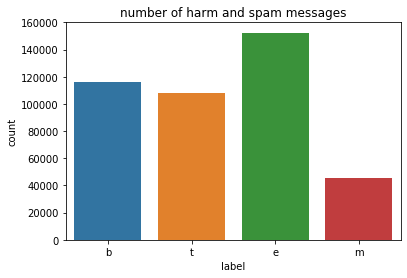

In [15]:
import seaborn as sns
sns.countplot(df.CATEGORY)
plt.xlabel('label')
plt.title("number of messages catagory")

In [4]:
#balancing to all classes
num_of_categories = 45000

shuffled = df.reindex(np.random.permutation(df.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]

concated = pd.concat([e,b,t,m],ignore_index=True)

#shuffle the dataset

concated = concated.reindex(np.random.permutation(concated.index))
concated['Label'] = 0

In [5]:
#One-hot encode the lab
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)

print(labels[:10])

if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)

162272    3.0
141322    3.0
59155     1.0
64006     1.0
62997     1.0
82759     1.0
12574     0.0
64520     1.0
48397     1.0
130560    2.0
Name: LABEL, dtype: float64
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


In [6]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 52212 unique tokens.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))


((135000, 130), (135000, 4), (45000, 130), (45000, 4))


In [8]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [9]:
def LSTM_model():
    model = Sequential()
    model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.7))
    model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [10]:
model = LSTM_model()
model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

W0819 17:55:38.754762  5224 deprecation_wrapper.py:119] From C:\Users\rajeevranjan.sharma\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 17:55:38.784820  5224 deprecation_wrapper.py:119] From C:\Users\rajeevranjan.sharma\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 17:55:38.791772  5224 deprecation_wrapper.py:119] From C:\Users\rajeevranjan.sharma\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 17:55:38.812287  5224 deprecation_wrapper.py:119] From C:\Users\rajeevranjan.sharma\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The n

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

W0819 17:55:40.021709  5224 deprecation.py:323] From C:\Users\rajeevranjan.sharma\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 108000 samples, validate on 27000 samples
Epoch 1/10
108000/108000 [==============================] - 122s 1ms/step - loss: 0.8574 - acc: 0.6540 - val_loss: 0.3393 - val_acc: 0.8844
Epoch 2/10
108000/108000 [==============================] - 116s 1ms/step - loss: 0.3849 - acc: 0.8686 - val_loss: 0.2664 - val_acc: 0.9087
Epoch 3/10
108000/108000 [==============================] - 116s 1ms/step - loss: 0.3117 - acc: 0.8948 - val_loss: 0.2450 - val_acc: 0.9164
Epoch 4/10
108000/108000 [==============================] - 119s 1ms/step - loss: 0.2776 - acc: 0.9069 - val_loss: 0.2359 - val_acc: 0.9192
Epoch 5/10
108000/108000 [==============================] - 117s 1ms/step - loss: 0.2526 - acc: 0.9154 - val_loss: 0.2312 - val_acc: 0.9217
Epoch 6/10
108000/108000 [==============================] - 117s 1ms/step - loss: 0.2417 - acc: 0.9188 - val_loss: 0.2277 - val_acc: 0.9234
Epoch 7/10
108000/108000 [==============================] - 118s 1ms/step - loss: 0.2305 - acc: 0.9224 - val_

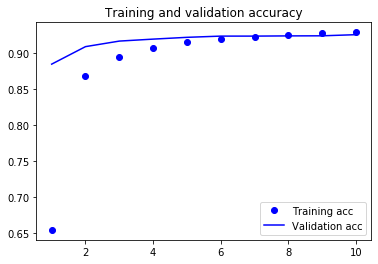

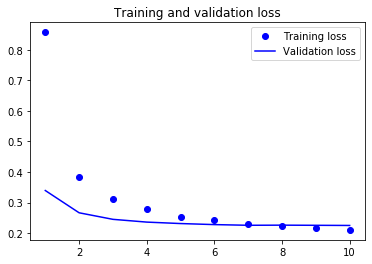

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# from sklearn.metrics import classification_report,confusion_matrix
# Y_pred = model.predict(X_test)
# y_pred = np.array([np.argmax(pred) for pred in Y_pred])
# print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')

#test on real data set

In [13]:
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[1.2241091e-04 3.8411265e-04 7.5775570e-05 9.9941766e-01]] health


In [18]:
txt = ["Get latest stock share market news, financial news, economy news, company news, politics news, India news, breaking news, Indian economy"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[1.6838530e-04 9.9792790e-01 1.7120638e-03 1.9162030e-04]] bussiness
